In [55]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


## Visualizing Sample Audio Signal

In [56]:
audio_file_name = "./disco.00000.wav"

In [57]:
y, sr = librosa.load(audio_file_name, sr=44100)

In [58]:
y

array([-0.22725154, -0.26514822, -0.23639536, ..., -0.13441333,
       -0.1039077 , -0.05058938], dtype=float32)

In [59]:
sr

44100

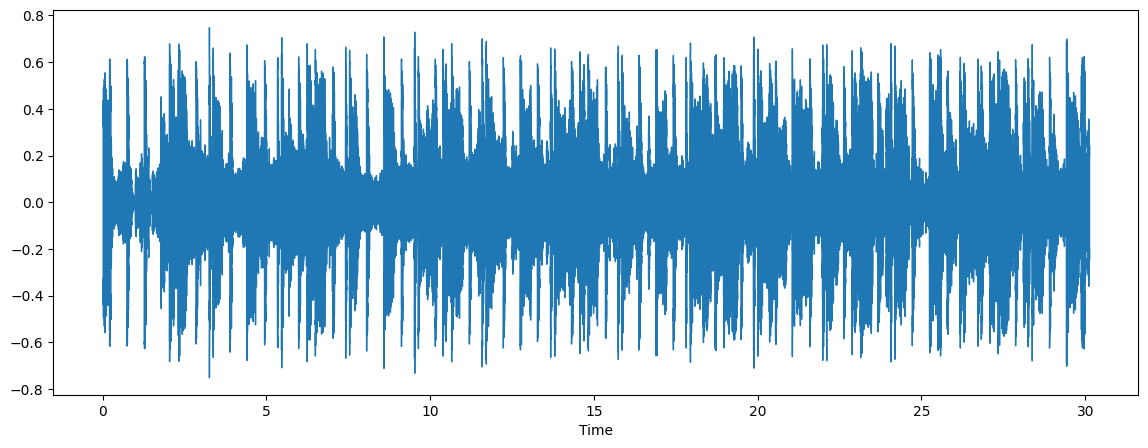

In [60]:
plt.figure(figsize=(14,5))
librosa.display.waveshow(y, sr=sr)

## Playing the audio 

In [61]:
from IPython.display import Audio
Audio(data = y, rate = sr)

### Now we will visualize the audio within chunks

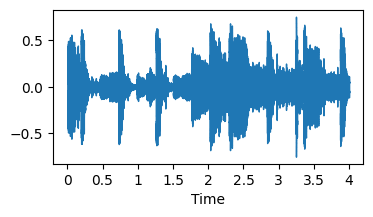

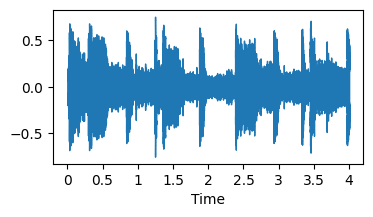

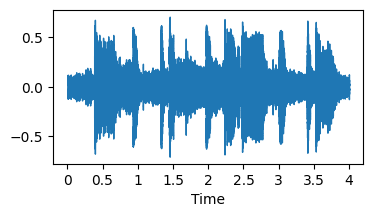

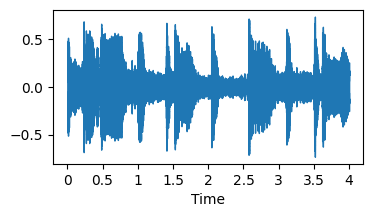

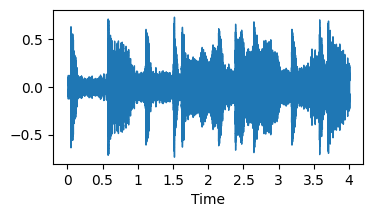

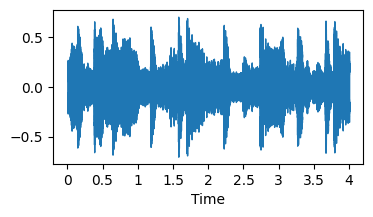

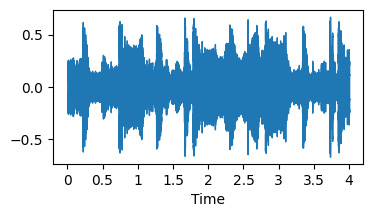

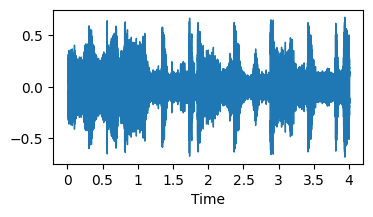

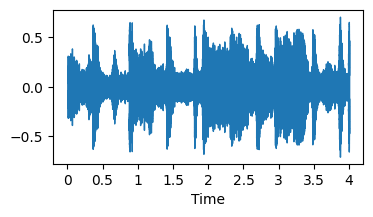

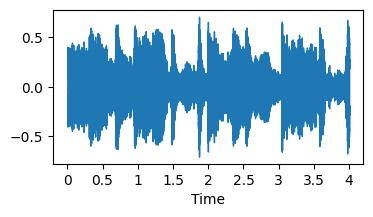

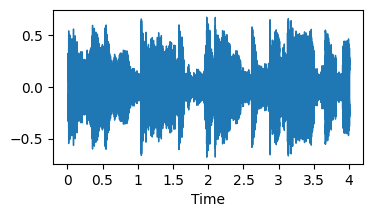

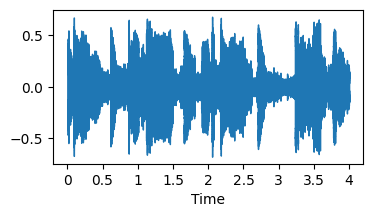

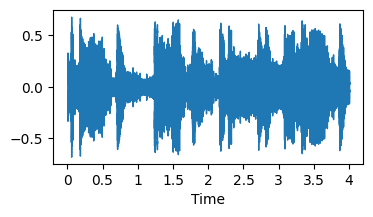

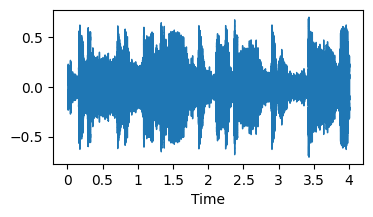

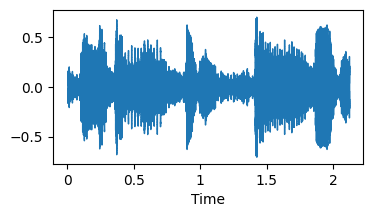

In [62]:
audio_for_chunks = "./blues.00000.wav"
y,sr = librosa.load(audio_file_name,sr=None) ##in order to preserve the original sampling rate

#defining custom chunk duration and overlap duration to analyze how the freq. contents change over time
#Overlapping gives smoother and more accurate representations of frequency transitions and avoids missing rapid changes
chunk_duration = 4
overlap_duration = 2
#Converting duration to sample
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

##Calculate start and end index values for chunks including the overlap regions
for i in range(num_chunks):
    start_index = i*(chunk_samples - overlap_samples)
    end_index = start_index + chunk_samples
    chunk = y[start_index:end_index]
    plt.figure(figsize=(4,2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()

In [63]:
num_chunks

15

In [64]:
def plot_melspectrogram(y,sr):
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    print(spectrogram.shape)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Melspectrogram")
    plt.tight_layout()
    plt.show()


(128, 1298)


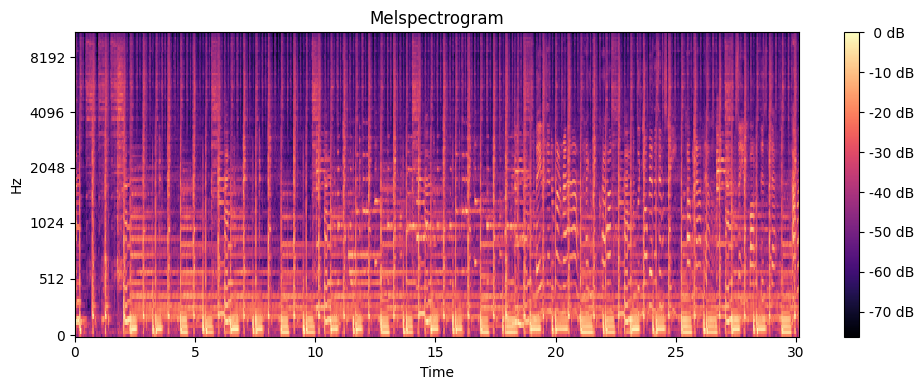

In [65]:
plot_melspectrogram(y,sr)

### Now we will plot the melspectrogram of chunks

In [66]:
def plot_melspectrogram_chunks(y,sr):
    chunk_duration = 4
    overlap_duration = 2

    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    ## We will plot the melspectrogram for each chunk
    for i in range(num_chunks):
        start_index = i*(chunk_samples - overlap_samples)
        end_index = start_index + chunk_samples
        chunk = y[start_index:end_index]
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        print(spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Melspectrogram")
        plt.tight_layout()
        plt.show()

(128, 345)


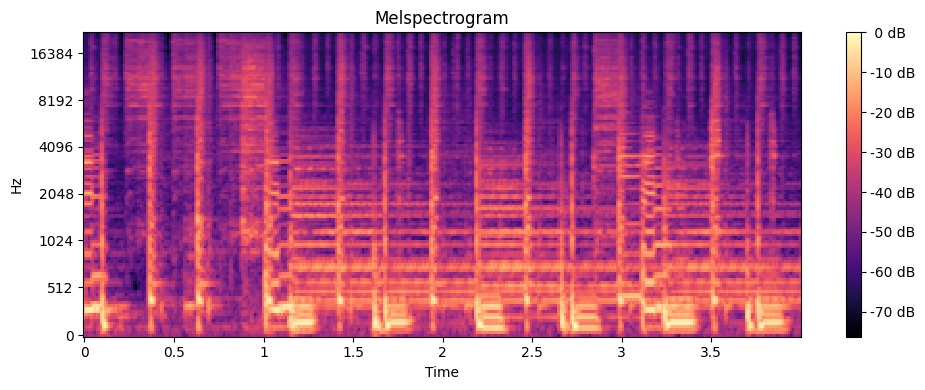

(128, 345)


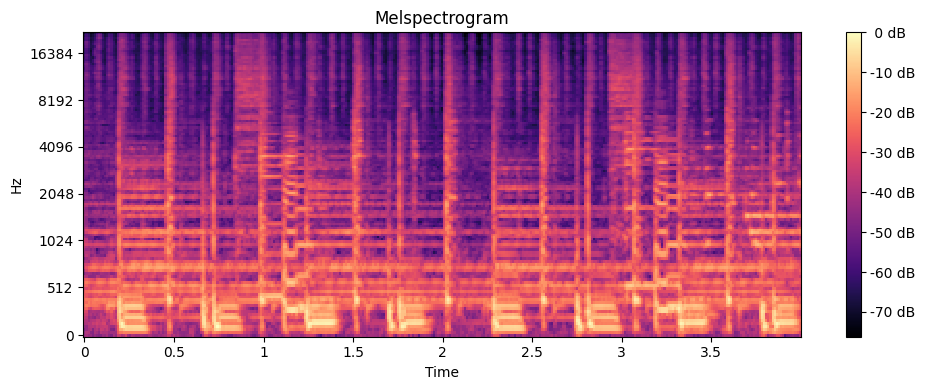

(128, 345)


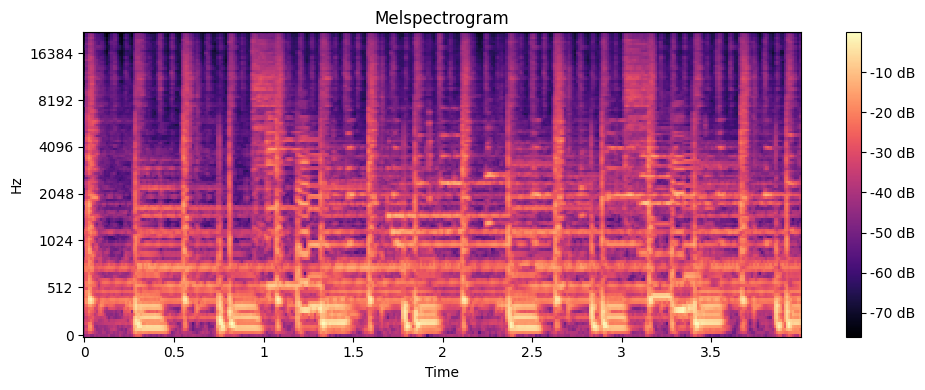

(128, 345)


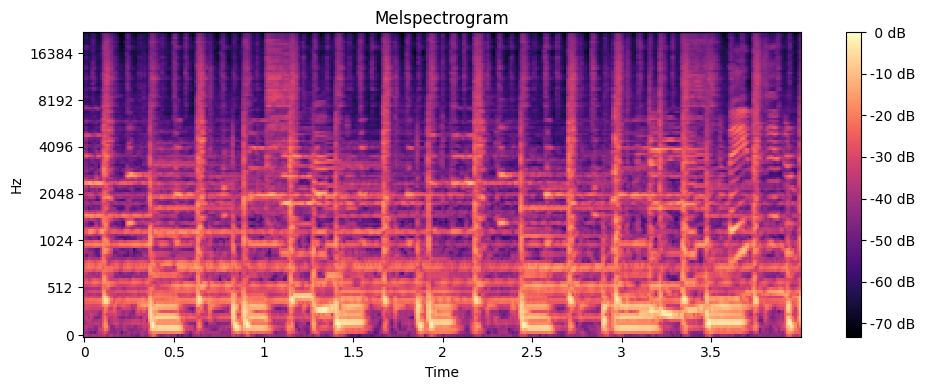

(128, 345)


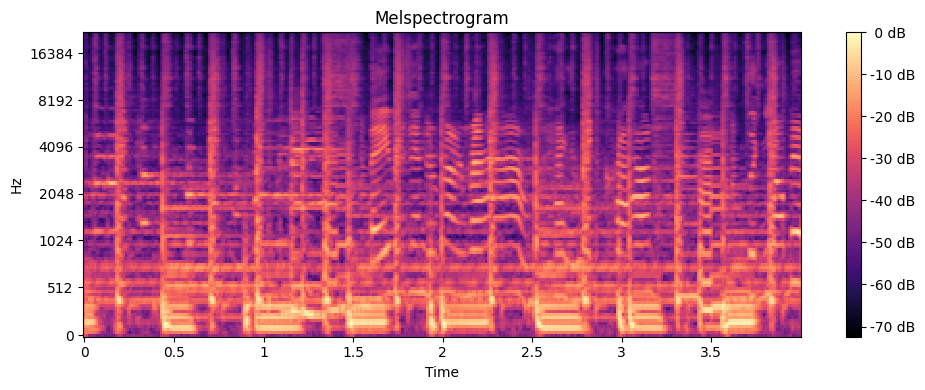

(128, 345)


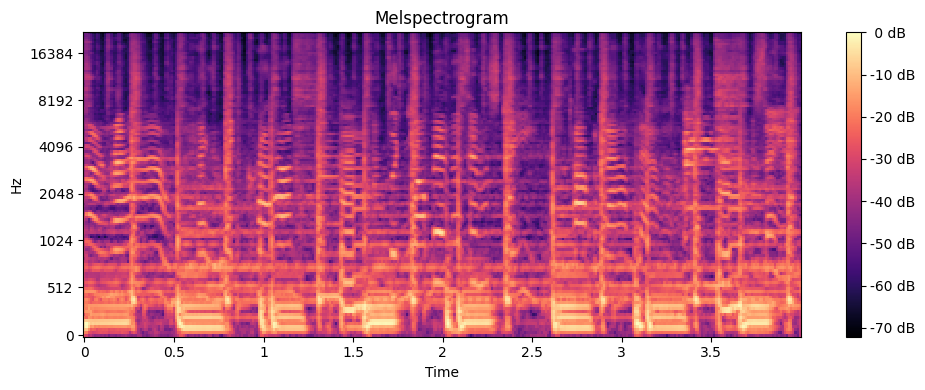

(128, 264)


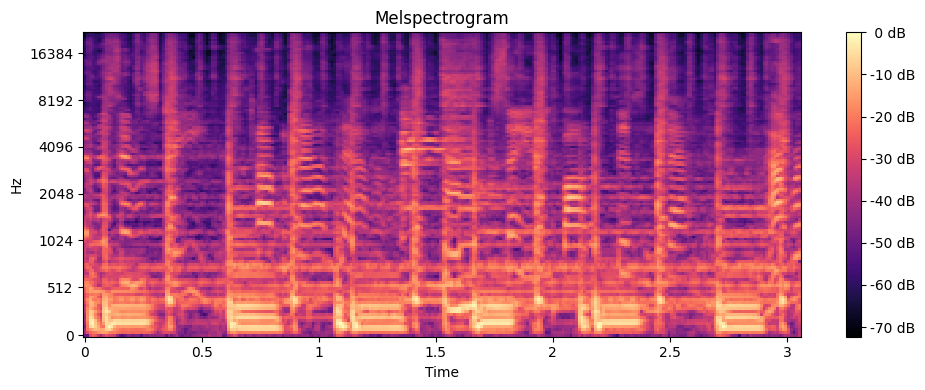

In [67]:
plot_melspectrogram_chunks(y,sr=44100)

## Data Preprocessing on Whole Data

In [68]:
data_dir = "./genres_original"
classes = ['blues','classical','country','disco','hiphop','metal','pop','reggae','rock'] 

In [69]:
from tensorflow.image import resize

#loading and preprocessing the audio data function
def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data = []
    labels = []

    for iClassIndex,class_label in enumerate(classes):
        class_dir = os.path.join(data_dir, class_label)
        print("Processing Class label--", class_label)
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            audio_data,sample_rate = librosa.load(file_path, sr=None) 
            
            chunk_duration = 4
            overlap_duration = 2

            chunk_samples = chunk_duration * sample_rate
            overlap_samples = overlap_duration * sample_rate

            num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
            ## We will plot the melspectrogram for each chunk
            for i in range(num_chunks):
                start_index = i*(chunk_samples - overlap_samples)
                end_index = start_index + chunk_samples
                chunk = audio_data[start_index:end_index]
                mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                #Resize matrix based on provided target shape
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(iClassIndex)
                
    return np.array(data), np.array(labels)

In [70]:
data,labels = load_and_preprocess_data(data_dir, classes)

Processing Class label-- blues
Processing Class label-- classical
Processing Class label-- country
Processing Class label-- disco
Processing Class label-- hiphop
Processing Class label-- metal
Processing Class label-- pop
Processing Class label-- reggae
Processing Class label-- rock


### When trying to processing class label jazz a problem has been occured removed from dataset

In [71]:
data.shape

(13490, 150, 150, 1)

In [72]:
labels.shape

(13490,)

In [73]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes = len(classes)) #Converting labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [74]:
labels.shape

(13490, 9)

## Splitting of Dataset into Training and Test Set

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [76]:
X_train.shape

(10792, 150, 150, 1)

In [77]:
X_test.shape

(2698, 150, 150, 1)

In [78]:
Y_train.shape

(10792, 9)

In [79]:
Y_test.shape

(2698, 9)

## Building the CNN Model Architecture

In [80]:
model = tf.keras.models.Sequential()

In [81]:
X_train[0].shape

(150, 150, 1)

In [82]:
model.add(Conv2D(filters=32, kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

In [83]:
model.add(Conv2D(filters=64, kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

In [84]:
model.add(Conv2D(filters=128, kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

In [85]:
model.add(Dropout(0.3))

In [86]:
model.add(Conv2D(filters=256, kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

In [87]:
model.add(Conv2D(filters=512, kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

In [88]:
model.add(Dropout(0.3))

In [89]:
model.add(Flatten())

In [90]:
model.add(Dense(units=1200, activation='relu'))

In [91]:
model.add(Dropout(0.45))

In [92]:
model.add(Dense(units=len(classes), activation='softmax'))

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                  

In [94]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
training_history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test)) ##run this cell to train a model

In [ ]:
model.save("Trained_model.h5")

In [ ]:
model.save("Trained_model.keras")

In [95]:
training_history.history

{'loss': [1.879036784172058,
  1.3057518005371094,
  1.057861089706421,
  0.8996613621711731,
  0.7748574614524841,
  0.6717998385429382,
  0.5702818036079407,
  0.499324232339859,
  0.4286518096923828,
  0.3692368268966675,
  0.31125497817993164,
  0.276654988527298,
  0.22690263390541077,
  0.20289579033851624,
  0.17930614948272705,
  0.1565077155828476,
  0.13855360448360443,
  0.11601316928863525,
  0.11960065364837646,
  0.11008943617343903,
  0.07477200031280518,
  0.0898992270231247,
  0.0732288733124733,
  0.08165361732244492,
  0.06515292823314667,
  0.06728013604879379,
  0.064182348549366,
  0.05757409334182739,
  0.04794738069176674,
  0.055069949477910995],
 'accuracy': [0.303372859954834,
  0.5409562587738037,
  0.6322275996208191,
  0.6890289187431335,
  0.735822856426239,
  0.7739065885543823,
  0.8085619211196899,
  0.831541895866394,
  0.8522980213165283,
  0.8738880753517151,
  0.8958487510681152,
  0.9082653522491455,
  0.9237397909164429,
  0.9314306974411011,
  0

In [96]:
#Record the history in json
import json
with open('training_hist.json','w') as f:
    json.dump(training_history.history, f)


In [97]:
with open('training_hist.json', 'r') as json_file:
    training_history_data = json.load(json_file)

In [98]:
training_history_data.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [99]:
model = tf.keras.models.load_model("Trained_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                    

## Now Model Evaluation will be performed on Both Training and Test Set

In [100]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [101]:
training_loss, training_accuracy = model.evaluate(X_train[:1000], Y_train[:1000])

32/32 [==============================] - 2s 48ms/step - loss: 0.0181 - accuracy: 0.9960


In [102]:
training_loss,training_accuracy

(0.018083013594150543, 0.9959999918937683)

In [103]:
validation_loss,validation_accuracy = model.evaluate(X_test, Y_test)

85/85 [==============================] - 4s 47ms/step - loss: 0.3142 - accuracy: 0.9107


In [104]:
validation_loss,validation_accuracy

(0.3142060935497284, 0.9106745719909668)

In [105]:
training_history_data['val_loss']

[1.4907621145248413,
 1.124497890472412,
 0.9223823547363281,
 0.8442990779876709,
 0.7552556395530701,
 0.7342338562011719,
 0.6720731258392334,
 0.5440149903297424,
 0.7804494500160217,
 0.4768044650554657,
 0.541447639465332,
 0.44588878750801086,
 0.5475003123283386,
 0.39477065205574036,
 0.3755081593990326,
 0.35477256774902344,
 0.3484448790550232,
 0.41463565826416016,
 0.3308192193508148,
 0.368671715259552,
 0.34885647892951965,
 0.40443840622901917,
 0.33673617243766785,
 0.38771921396255493,
 0.34223103523254395,
 0.42143797874450684,
 0.49789363145828247,
 0.4198274612426758,
 0.4244653880596161,
 0.5989708304405212]

In [106]:
training_history_data['val_accuracy']

[0.47405484318733215,
 0.6189770102500916,
 0.6808747053146362,
 0.7112675905227661,
 0.741660475730896,
 0.746849536895752,
 0.7657524347305298,
 0.8131949305534363,
 0.7538917660713196,
 0.8395107388496399,
 0.8320978283882141,
 0.8517420291900635,
 0.8339510560035706,
 0.8713862299919128,
 0.88176429271698,
 0.8869532942771912,
 0.8921423554420471,
 0.88176429271698,
 0.8995552062988281,
 0.8943662047386169,
 0.9043735861778259,
 0.8965900540351868,
 0.9091919660568237,
 0.8962194323539734,
 0.908450722694397,
 0.8828762173652649,
 0.8687916994094849,
 0.9080800414085388,
 0.8999258875846863,
 0.8598962426185608]

## Accuracy and Loss Visualization

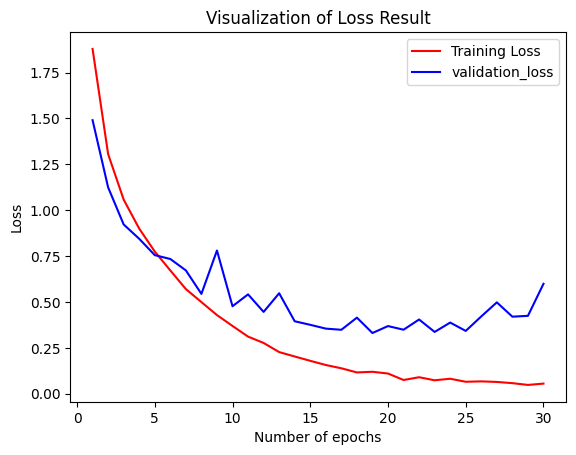

In [107]:
epochs = [i for i in range(1,31)]
plt.plot(epochs, training_history_data['loss'], label="Training Loss", color='red')
plt.plot(epochs, training_history_data['val_loss'], label = "validation_loss", color="blue")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

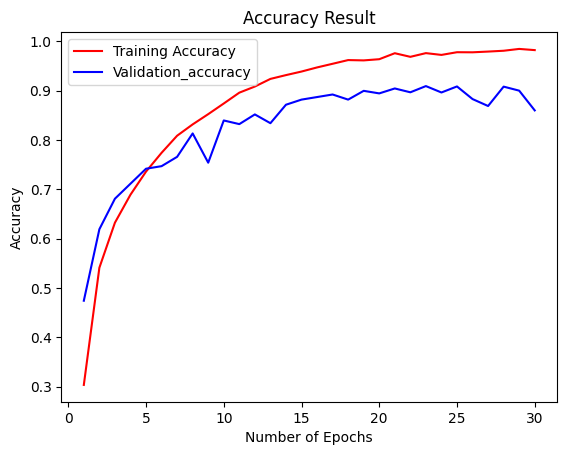

In [108]:
epochs = [i for i in range(1,31)]
plt.plot(epochs, training_history_data['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, training_history_data['val_accuracy'], label="Validation_accuracy", color='blue')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Result")
plt.legend()
plt.show()

## Recall, Precision, Confusion Matrix

In [109]:
y_predicted = model.predict(X_test)

85/85 [==============================] - 4s 45ms/step


In [110]:
y_predicted

array([[6.3078798e-04, 8.1653307e-06, 9.9676180e-01, ..., 4.5604836e-05,
        2.2923028e-05, 2.5296884e-03],
       [8.8438094e-01, 2.0111682e-07, 6.6454181e-06, ..., 3.2848408e-07,
        1.0860174e-01, 5.7980640e-05],
       [6.8366346e-05, 3.3008558e-08, 9.9710947e-01, ..., 5.7533617e-07,
        2.8202976e-03, 7.1556281e-07],
       ...,
       [2.6133556e-10, 6.7165131e-09, 2.4057712e-08, ..., 9.9954635e-01,
        2.2304666e-06, 1.9225834e-07],
       [1.5283653e-08, 3.9645350e-08, 9.9999893e-01, ..., 1.0007601e-06,
        1.5003028e-08, 1.4588409e-08],
       [6.7905637e-07, 5.7432683e-13, 7.0021211e-10, ..., 5.0723703e-10,
        2.1208899e-09, 4.7859330e-06]], dtype=float32)

In [111]:
y_predicted.shape

(2698, 9)

In [112]:
predicted_categories = np.argmax(y_predicted,axis=1)
predicted_categories

array([2, 0, 2, ..., 6, 2, 5], dtype=int64)

In [113]:
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [114]:
Y_test.shape

(2698, 9)

In [115]:
actual_categories = np.argmax(Y_test,axis=1)
actual_categories

array([2, 0, 2, ..., 6, 2, 5], dtype=int64)

In [116]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'metal',
 'pop',
 'reggae',
 'rock']

In [117]:
from sklearn.metrics import confusion_matrix,classification_report
conf_matrix = confusion_matrix(actual_categories, predicted_categories)

In [118]:
print(classification_report(actual_categories, predicted_categories, target_names=classes))

              precision    recall  f1-score   support

       blues       0.91      0.93      0.92       316
   classical       0.92      0.99      0.95       291
     country       0.93      0.85      0.89       326
       disco       0.94      0.89      0.91       289
      hiphop       0.94      0.95      0.94       295
       metal       0.97      0.90      0.94       298
         pop       0.97      0.90      0.93       318
      reggae       0.91      0.94      0.92       273
        rock       0.75      0.86      0.80       292

    accuracy                           0.91      2698
   macro avg       0.91      0.91      0.91      2698
weighted avg       0.91      0.91      0.91      2698



In [119]:
conf_matrix

array([[294,   0,   5,   1,   0,   0,   2,   6,   8],
       [  1, 288,   1,   0,   0,   0,   0,   0,   1],
       [  9,  10, 277,   0,   0,   1,   3,   0,  26],
       [  4,   1,   5, 256,   3,   0,   0,   8,  12],
       [  1,   3,   0,   1, 281,   2,   1,   4,   2],
       [  2,   0,   2,   1,   3, 269,   0,   0,  21],
       [  4,   3,   3,   5,   4,   1, 286,   1,  11],
       [  3,   1,   0,   3,   5,   0,   1, 256,   4],
       [  5,   8,   5,   6,   4,   4,   3,   7, 250]], dtype=int64)

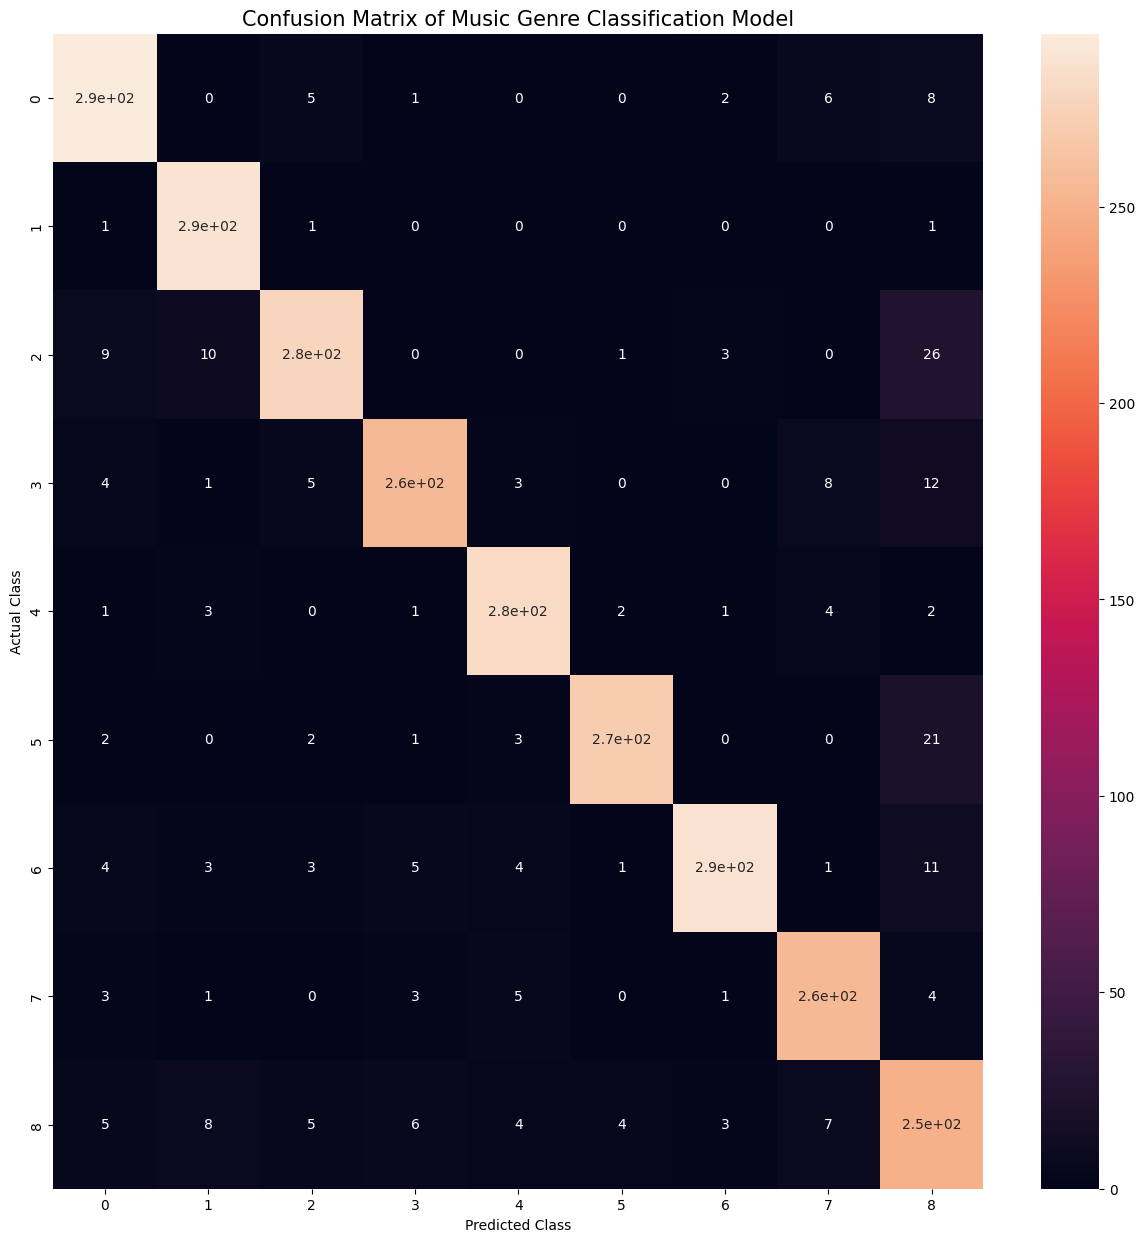

In [120]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size":10})
plt.ylabel("Actual Class",fontsize=10)
plt.xlabel("Predicted Class",fontsize=10)
plt.title("Confusion Matrix of Music Genre Classification Model",fontsize=15)
plt.show()
